Focus project
step 1:

Calculate max number of starts using newton formula:

Limit to 10GB of memory and 10s of processing time for one iteration.



## Imports

In [1]:
# Imports

# From python
import time


import psutil
import subprocess

import traceback

import gc
import sys
from sys import getsizeof



# Libraries
import matplotlib.pyplot as plt
import numpy as np




## Measure Functions performance

In [2]:
from accelerations import acceleration_functions_dic


[Taichi] version 1.7.3, llvm 15.0.4, commit 5ec301be, linux, python 3.12.3


[I 07/07/25 00:13:26.206 526003] [shell.py:_shell_pop_print@23] Graphical python shell detected, using wrapped sys.stdout


[Taichi] Starting on arch=vulkan


[W 07/07/25 00:13:26.745 526003] [cuda_driver.cpp:load_lib@36] libcuda.so lib not found.


In [3]:
# Remove jax3 since its a failed attempt.
del acceleration_functions_dic["jax3"] 

In [4]:
def time_algorithm_with_limits(function_name: str, N: int, max_mem_mb=1024, max_time_sec=10, script_path="accelerations.py"):
    mem_limit = False
    time_limit = False

    # Start subprocess
    # print(f"Starting process {script_path}:{function_name}")
    process = subprocess.Popen(
        ["python", script_path, function_name, str(N)],
        stdout=subprocess.PIPE,
        stderr=subprocess.PIPE,
        text=True
    )
    start_time = time.time()

    proc = psutil.Process(process.pid)
    try:
        while process.poll() is None:
            mem = proc.memory_info().rss / 1024**2  # Memory in MB
            current_duration = time.time() - start_time
            if mem > max_mem_mb:
                # print(f"[!] Exceeded memory {mem}/{max_mem_mb} or time {current_duration}/{max_time_sec} Killing process.")
                process.terminate()
                mem_limit = True
                break
            # Add 5 extra secs to account for fork and array init
            if current_duration > max_time_sec + 5:
                # print(f"[!] Exceeded memory {mem}/{max_mem_mb} or time {current_duration}/{max_time_sec} Killing process.")
                process.terminate()
                time_limit = True
                break
            time.sleep(0.1)
    except psutil.NoSuchProcess:
        pass
    process.wait()
    current_duration = time.time() - start_time

    stdout, stderr = process.communicate()

    wtime = current_duration
    if not (mem_limit or time_limit):
        if process.returncode == 0:
                wtime = float(stdout.strip().split()[-1])
        else:
            print("")
            print(f"stdout:{stdout}")
            print(f"stderr:{stderr}")

    return wtime, mem, (time_limit, mem_limit)


In [21]:
def time_algorithm(algo, N):
    X = np.random.rand(N, 3)
    print(
        f"N:{N:_} size:{getsizeof(X)/(1024**2):.2f} MB, sizenp:{X.nbytes/(1024**2):.2f}"
    )
    start = time.time()
    r = algo(X)
    elapsed_time = time.time() - start
    print(sys.getrefcount(r), sys.getrefcount(X))
    # r.resize((0, 0), refcheck=False)
    # X.resize((0, 0), refcheck=False)
    del r
    del X
    gc.collect()
    return elapsed_time


# Local path works only if the jupyter kernel was started on the same folder as this file.
acc_file_path = (
    "accelerations.py"
)


def verify_complexity(func_name):
    # algo = acceleration_functions_dic[func_name]
    wtime = []
    mem_usage = []
    stopped_arr = []

    # n_values = [int(starting_size * 10**i) for i in range(0, steps)]
    n_values = [int(n) for n in np.logspace(2,8,13)]
    tested_n = []
    for N in n_values:
        elapsed_time, memory_used, limits = time_algorithm_with_limits(
            func_name, N, script_path=acc_file_path
        )
        print(f"{N:_}: {elapsed_time} {memory_used}")

        wtime.append(elapsed_time)
        mem_usage.append(memory_used)
        stopped_arr.append(limits)
        tested_n.append(N)
        if any(limits):
            print(
                f"Limits {[l for f,l in zip(limits,['time','mem']) if f]} hit: {elapsed_time} {memory_used}"
            )
            break
    return tested_n, wtime, mem_usage

def plot_complexity(algorithms_data):
    plt.figure(figsize=(10, 10))
    for algo, (n_values, wtime, mem_usage) in algorithms_data.items():
        plt.plot(n_values[:-1], wtime[:-1], marker="o", label=algo)
        # for x,y in zip(n_values, wtime):
        # plt.text(x,y, f"{y:.0e}")
    plt.xscale("log")
    plt.yscale("log")
    plt.xlabel("N")
    plt.ylabel("Wall-clock time (s)")
    # plt.grid(which='minor', color='gray', linestyle='--', linewidth=0.5)
    # plt.minorticks_on()
    plt.grid()
    plt.legend()
    plt.title(f"Time Comparison")
    plt.show()


def plot_memory(algorithms_data):
    plt.figure(figsize=(10, 10))
    algo_lines = {}
    for algo, (n_values, wtime, mem_usage) in algorithms_data.items():
        line = plt.plot(n_values, mem_usage, marker="o", label=algo)
        algo_lines[algo]=line
        # for x, y in zip(n_values, wtime):
            # plt.text(x, y, f"{x:.0e}")
    plt.xscale("log")
    # plt.yscale("log")
    plt.xlabel("N")
    plt.ylabel("Memory usage (MB)")
    plt.grid()
    plt.legend()
    plt.title(f"Space Comparison (approx)")
    # plt.show()
    return algo_lines

In [6]:
algorithms_complexity = {}
for func_name in acceleration_functions_dic:
    print(func_name)
    try:
        algorithms_complexity[func_name] = verify_complexity(
            func_name,
        )
    except Exception as e:
        print(f"{type(e).__name__}: {e}")
        print(traceback.format_exc())       


naive_loops
100: 0.055454254150390625 261.10546875
316: 0.9629697799682617 0.0
1_000: 4.291157960891724 260.53125
3_162: 15.088947534561157 260.62109375
Limits ['time'] hit: 15.088947534561157 260.62109375
numpy
100: 0.0011243820190429688 247.71484375
316: 0.010243415832519531 0.0
1_000: 0.15220880508422852 248.703125
3_162: 1.2850744724273682 259.1328125
10_000: 2.0342307090759277 1074.2265625
Limits ['mem'] hit: 2.0342307090759277 1074.2265625
naive_loops_numba
100: 0.0021975040435791016 322.82421875
316: 0.034903764724731445 323.30859375
1_000: 0.29628777503967285 0.0
3_162: 15.112191677093506 334.79296875
Limits ['time'] hit: 15.112191677093506 334.79296875
numba_parallel
100: 0.0006771087646484375 332.48046875
316: 0.0029494762420654297 344.7890625
1_000: 0.04700779914855957 332.34765625
3_162: 0.45630693435668945 331.01171875
10_000: 15.121052265167236 344.61328125
Limits ['time'] hit: 15.121052265167236 344.61328125
jax
100: 0.0003402233123779297 324.0078125
316: 0.0013043880462

In [7]:
algorithms_complexity.keys()

dict_keys(['naive_loops', 'numpy', 'naive_loops_numba', 'numba_parallel', 'jax', 'jax2', 'taichi'])

In [8]:
# del algorithms_complexity["jax3"]
# func_name = "jax3"
# algorithms_complexity[func_name] = verify_complexity(
#             func_name,
#             steps=10,
#             starting_size=10,
#         )

In [9]:
# plt.style.use('dark_background')

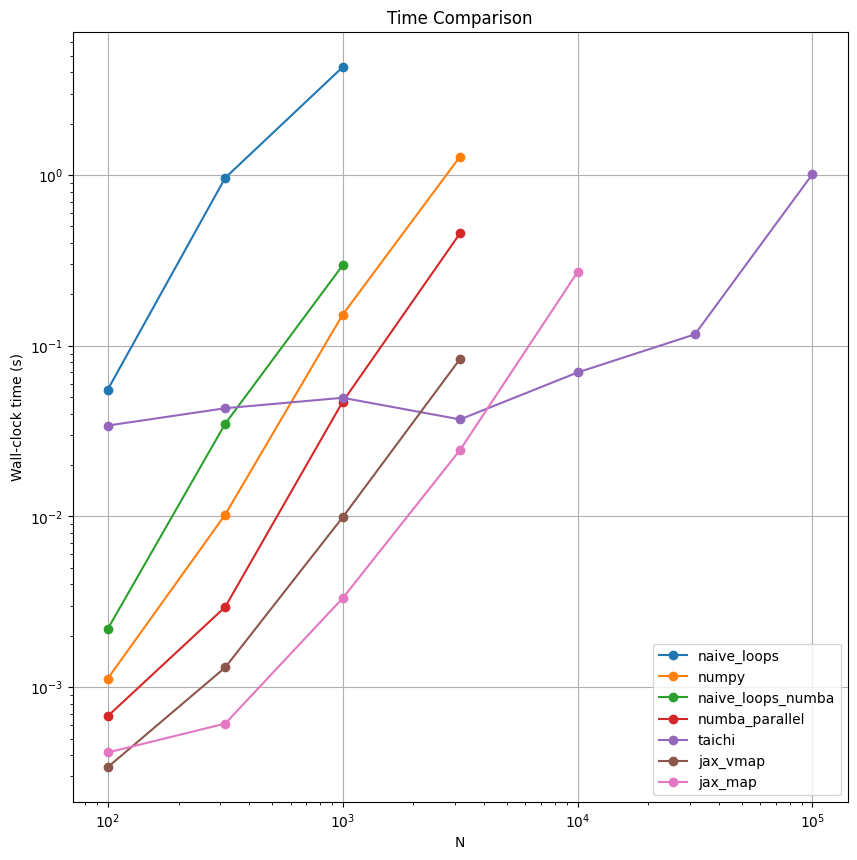

In [29]:
plot_complexity(algorithms_complexity)

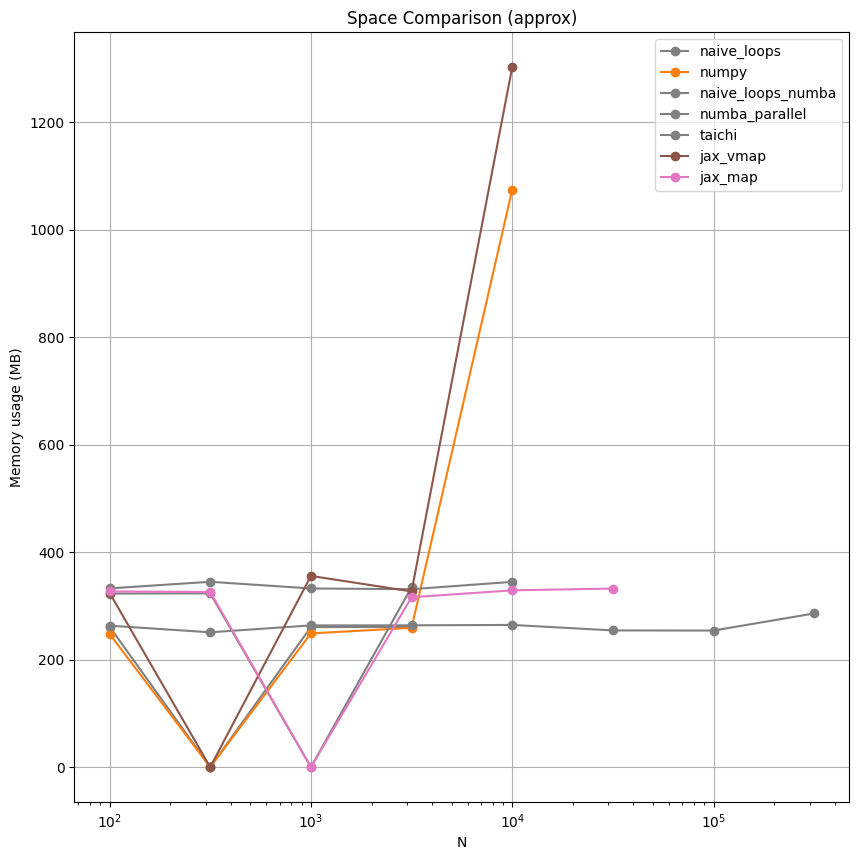

In [30]:
lines = plot_memory(algorithms_complexity)
lines["naive_loops"][0].set_color("grey")
lines["numba_parallel"][0].set_color("grey")
lines["taichi"][0].set_color("grey")
lines["naive_loops_numba"][0].set_color("grey")
plt.legend()
plt.show()

In [19]:
lines["jax"][0].set_color("grey")